### 2019 Data Science Bowl

#### Description and Challenge of the project
<br> https://www.kaggle.com/c/data-science-bowl-2019/overview
<br> In this project game analytics data for kids given by PBS KIDS. In this app kids can play
<br> games, watch clips and perform different activities and after some game session they are assigned 
<br> test.Kids can take multiple tests or single test or many records for kids with no test.
<br> If they cam solve test correctly in single attempt then their accuracy group is 3, if two attempt
<br> to solve correctly then accuracy group is 2, if multiple atempts then 1 if could not solve then 0.
<br> Dataset is hierchical. For every apps installed, one installation id is assigned. We can consider
<br> one kid has one installation id (assuming no shared device). One kid can play multiple game sessions
<br> and one game session might have multiple events. Some of the variables like activity types, title, world
<br> etc. are in game session level and some event related variables are at lower level.
<br> Target variable is accuracy group.
<br> The challenge is in train data accuracy group is at game session level
<br> but we have to predict in test data at installation id level, in higher level.
<br> Moreover only 1000 test records are given but Kaggle is measuring accuracy on 8 MM records.

#### Approach for this notebook
<br> Feature engineering is done using inetrmedate panda data frame.
<br> For training data , assessment game sessions identified and extracted some features.
<br> Then a look up table is created to capture all activities before assessment.
<br> Here assumption is that activities before  assessment will impact accuracy.
<br> After that , different features created mainly number of activities and game time.
<br> Irrelevent features are excluded before model building. 
<br> Different models and hyperparameter tuning performed.
<br> XGBoost and Deep Learning in Keras framework presented here.
<br> Same feature extraction strategy applied to test data primrily but did not go very well.
<br> For test data similar approach but at installation id levels features extraction performed.
<br> Final scores measured using Cohen-Kappa score.

##### Importing Required modules and load data

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor
from matplotlib import pyplot
from time import time
from collections import Counter
import datetime
from sklearn.metrics import cohen_kappa_score, mean_squared_error
from sklearn.model_selection import KFold, StratifiedKFold,train_test_split
from sklearn.model_selection import GridSearchCV,RandomizedSearchCV
import gc
import json
pd.set_option('display.max_columns', 1000)
import warnings
warnings.filterwarnings("ignore")

In [2]:
path_ind='local'

if path_ind=='kaggle':
    file_path="/kaggle/input/data-science-bowl-2019"
else:
    file_path="/Users/krishanubanerjee/Downloads/data-science-bowl-2019"
    

train=pd.read_csv(file_path+"/train.csv")
train_labels=pd.read_csv(file_path+"/train_labels.csv")
test=pd.read_csv(file_path+"/test.csv")
sample_submission=pd.read_csv(file_path+"/sample_submission.csv")

##### Feature Engineering for Train Test

In [3]:
def acc_grp_calc(x):
    """
    This function will assign accuracy to accuracy group
    """
    if x==0:
        return(0)
    elif x==1:
        return(3)
    elif x==0.5:
        return(2)
    else:
        return(1)

In [4]:
def get_assessment_df(input_flg):
    """
    This function will identify assessment for train or test and create some related features
    from different assessments and related titles. This function will also derive fetures from 
    multiple assessment takers cumulatively
    """
    assert ((input_flg == 'train') | (input_flg == 'test')),"Input is not train or test"
    if input_flg=='train':
        df_ass=train[train['type']=='Assessment']\
             [((train['event_code']==4100)&(train['title']!='Bird Measurer (Assessment)'))\
             |((train['event_code']==4110)&(train['title']=='Bird Measurer (Assessment)'))]
    else:
        df_ass=test[test['type']=='Assessment']
        
    df_ass['correct_attempt']=np.where(df_ass['event_data'].str.contains('true'),1,0)
    df_ass['incorrect_attempt']=np.where(df_ass['event_data'].str.contains('false'),1,0)
    df_ass=df_ass.groupby(['installation_id','game_session','title']).agg({'correct_attempt':'sum',\
                                                          'incorrect_attempt':'sum'}).reset_index()
    df_ass['accuracy']=np.where(df_ass['correct_attempt']+df_ass['incorrect_attempt']==0,0,\
             round(df_ass['correct_attempt']/(df_ass['correct_attempt']+df_ass['incorrect_attempt']),1))
    df_ass['accuracy_group']=df_ass['accuracy'].apply(lambda x:acc_grp_calc(x))
    df_ass['accumulated_correct']=df_ass.groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['accumulated_incorrect']=df_ass.groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    # correct and incorrect attempt by type of assessment
    df_ass['Mushroom_sorter_correct']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Mushroom_sorter_incorrect']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Bird_Measurer_correct']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Bird_Measurer_incorrect']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cauldron_Filler_correct']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cauldron_Filler_incorrect']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cart_Balancer_correct']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cart_Balancer_incorrect']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Chest_Sorter_correct']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Chest_Sorter_incorrect']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass=df_ass.drop(['title'],axis=1)
    #  Cumulative accuracy group
    df_ass['accuracy_0']=np.where(df_ass['accuracy_group']==0,1,0)
    df_ass['accuracy_0']=df_ass.groupby('installation_id').agg({'accuracy_0':np.cumsum})
    df_ass['accuracy_1']=np.where(df_ass['accuracy_group']==1,1,0)
    df_ass['accuracy_1']=df_ass.groupby('installation_id').agg({'accuracy_1':np.cumsum})
    df_ass['accuracy_2']=np.where(df_ass['accuracy_group']==2,1,0)
    df_ass['accuracy_2']=df_ass.groupby('installation_id').agg({'accuracy_2':np.cumsum})
    df_ass['accuracy_3']=np.where(df_ass['accuracy_group']==3,1,0)
    df_ass['accuracy_3']=df_ass.groupby('installation_id').agg({'accuracy_3':np.cumsum})
    
    
    df_ass['cumcnt']=df_ass.groupby('installation_id').cumcount()
    df_ass=df_ass.drop(['correct_attempt','incorrect_attempt','accuracy'],axis=1)

    df_ass=df_ass.fillna(0)
    if input_flg=='train':
        df_ass=df_ass.drop(['cumcnt'],axis=1)
    else:
        df_ass=df_ass.drop(['cumcnt','accuracy_group'],axis=1)
    return(df_ass)

In [5]:
def get_assessment_test_df(input_flg):
    """
    This function will get assessment for Test and extract related features
    """
    assert (input_flg == 'test'),"Input is not test"
    df_ass=test[test['type']=='Assessment']   
    df_ass['correct_attempt']=np.where(df_ass['event_data'].str.contains('true'),1,0)
    df_ass['incorrect_attempt']=np.where(df_ass['event_data'].str.contains('false'),1,0)
    df_ass=df_ass.groupby(['installation_id','title']).agg({'correct_attempt':'sum',\
                                                          'incorrect_attempt':'sum'}).reset_index()
    df_ass['accuracy']=np.where(df_ass['correct_attempt']+df_ass['incorrect_attempt']==0,0,\
             round(df_ass['correct_attempt']/(df_ass['correct_attempt']+df_ass['incorrect_attempt']),1))
    df_ass['accuracy_group']=df_ass['accuracy'].apply(lambda x:acc_grp_calc(x)) 
    df_ass['accumulated_correct']=df_ass.groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['accumulated_incorrect']=df_ass.groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    # correct and incorrect attempt by type of assessment
    df_ass['Mushroom_sorter_correct']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Mushroom_sorter_incorrect']=df_ass[df_ass['title']=='Mushroom Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Bird_Measurer_correct']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Bird_Measurer_incorrect']=df_ass[df_ass['title']=='Bird Measurer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cauldron_Filler_correct']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cauldron_Filler_incorrect']=df_ass[df_ass['title']=='Cauldron Filler (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Cart_Balancer_correct']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Cart_Balancer_incorrect']=df_ass[df_ass['title']=='Cart Balancer (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    df_ass['Chest_Sorter_correct']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'correct_attempt':np.cumsum})
    df_ass['Chest_Sorter_incorrect']=df_ass[df_ass['title']=='Chest Sorter (Assessment)']\
                               .groupby('installation_id').agg({'incorrect_attempt':np.cumsum})
    #  Cumulative accuracy group
    df_ass['accuracy_0']=np.where(df_ass['accuracy_group']==0,1,0)
    df_ass['accuracy_0']=df_ass.groupby('installation_id').agg({'accuracy_0':np.cumsum})
    df_ass['accuracy_1']=np.where(df_ass['accuracy_group']==1,1,0)
    df_ass['accuracy_1']=df_ass.groupby('installation_id').agg({'accuracy_1':np.cumsum})
    df_ass['accuracy_2']=np.where(df_ass['accuracy_group']==2,1,0)
    df_ass['accuracy_2']=df_ass.groupby('installation_id').agg({'accuracy_2':np.cumsum})
    df_ass['accuracy_3']=np.where(df_ass['accuracy_group']==3,1,0)
    df_ass['accuracy_3']=df_ass.groupby('installation_id').agg({'accuracy_3':np.cumsum})
    
    df_ass=df_ass.drop(['correct_attempt','incorrect_attempt','accuracy','accuracy_group','title'],axis=1)
    df_ass=df_ass.groupby(['installation_id']).agg({k:'sum' for k in df_ass.columns if k!='installation_id' }).reset_index()

    df_ass=df_ass.fillna(0)
    return(df_ass)

In [6]:
def get_subset_tm_event_cnt(df_input):
    """
    This function will create features for maximum event and game time for all game sessions
    """
    subset_tm_cnt=df_input.groupby(['installation_id','game_session'])\
                                    .agg({'game_time':['max'],\
                                          'event_count':['max']}).reset_index()
    subset_tm_cnt.columns=['installation_id','game_session','gm_tm_max','evnt_max']
    subset_tm_cnt=subset_tm_cnt.fillna(0)

    return(subset_tm_cnt)

In [7]:
def get_subset_tm_event_cnt_test(df_input):
    """
    Extract average game time and event featires for test specific
    """
    subset_tm_cnt=df_input.groupby(['installation_id','game_session'])\
                                    .agg({'game_time':['max'],\
                                          'event_count':['max']}).reset_index()
    subset_tm_cnt.columns=['installation_id','game_session','gm_tm_max','evnt_max']
    subset_tm_cnt=subset_tm_cnt.fillna(0)
    subset_tm_cnt=subset_tm_cnt.groupby(['installation_id'])\
                            .agg({'gm_tm_max':['max','mean','std'],'evnt_max':['max','mean','std']}).reset_index()
    return(subset_tm_cnt)

In [8]:
def lkp_sessons_bfr_assignement(df_input,df_ass):
    """
    Look up for train to identify all game sessions before assessment.
    This will be used for other feature extraction
    """

    df_exp=df_input[['timestamp','game_session','installation_id']]
    df_exp=df_exp.groupby(['game_session','installation_id']).agg({'timestamp':'max'}).reset_index()

    df_gm_ass=df_exp[(df_exp['installation_id'].isin(list(df_ass['installation_id'].unique())))&\
                    (df_exp['game_session'].isin(list(df_ass['game_session'].unique())))]
    df_gm_ass=df_gm_ass.rename(columns={"game_session": "target_game_session", "timestamp": "target_timestamp"})
    df_gm_ass['order']=df_gm_ass.sort_values('target_timestamp').groupby('installation_id').cumcount()
    df_gm_ass_max=df_gm_ass.groupby(['installation_id']).agg({'target_timestamp':'max'}).reset_index()
    
    df_lkp=pd.merge(df_exp,df_gm_ass_max,left_on='installation_id',right_on='installation_id')
    df_lkp=df_lkp[df_lkp['timestamp']<=df_lkp['target_timestamp']]
    df_lkp=df_lkp.drop(['target_timestamp'],axis=1)
    df_lkp=pd.merge(df_lkp,df_gm_ass,left_on=['installation_id','game_session'],
                     right_on=['installation_id','target_game_session'],how='left')\
                        .sort_values(by=['installation_id','timestamp'])
    df_lkp['target_game_session']=df_lkp['target_game_session'].fillna(method='bfill')
    df_lkp['order']=df_lkp['order'].fillna(method='bfill').astype(int)
    df_lkp=df_lkp.drop(['timestamp','target_timestamp'],axis=1)
    return(df_lkp)

In [9]:
def get_avg_gm_tm_event_cnt(tm_event_cnt,df_lkp):
    """
    Get average event and game related features
    """
    df_avg_tm_event_cnt=pd.merge(tm_event_cnt,df_lkp,on=['installation_id','game_session'])
    df_avg_tm_event_cnt=df_avg_tm_event_cnt.drop(['game_session'],axis=1)
    df_avg_tm_event_cnt=df_avg_tm_event_cnt.groupby(['installation_id','target_game_session'])\
                        .agg({'gm_tm_max':['max','mean','std'],'evnt_max':['max','mean','std']}).reset_index()
    df_avg_tm_event_cnt=df_avg_tm_event_cnt.rename(columns={"target_game_session": "game_session"})
    return(df_avg_tm_event_cnt)

In [10]:
def get_event_history_data(df_input,df_lkp,val):
    """
    Activity history by installation id,game session
    """ 
    df_subset=df_input[['installation_id','game_session',val]]
    df_subset=df_subset.groupby(['installation_id','game_session',val]).agg({val:'count'})
    df_subset=df_subset.rename(columns={val:'total'}).reset_index()
    df_subset[val]=df_subset[val].astype(str)

    df_pivot=df_subset.pivot_table(index=['installation_id','game_session'],columns=val,values='total').reset_index()
    df_pivot=df_pivot.fillna(0)
    
    train_col=[str(x) for x in list(df_pivot.columns) if x not in ['installation_id','game_session']]
    df_pivot=pd.merge(df_pivot,df_lkp,on=['installation_id','game_session'])
    df_pivot=df_pivot.drop(['game_session'],axis=1)
    df_pivot=df_pivot.groupby(['installation_id','target_game_session','order'])\
                            .agg({i:'sum' for i in train_col }).reset_index()
    df_pivot=df_pivot.rename(columns={"target_game_session": "game_session"})
    for i in train_col:
        df_pivot[str('cumcnt_')+i]=df_pivot.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})
    df_pivot=df_pivot.drop(list(set(train_col)|{'order'}),axis=1)
    return(df_pivot)

In [11]:
def get_event_history_data_test(df_input,val):
    """
    Activity history for test at installation id level
    """
    df_subset=df_input[['installation_id',val]]
    df_subset=df_subset.groupby(['installation_id',val]).agg({val:'count'})
    df_subset=df_subset.rename(columns={val:'total'}).reset_index()
    df_subset[val]=df_subset[val].astype(str)
    df_pivot=df_subset.pivot_table(index=['installation_id'],columns=val,values='total').reset_index()
    df_pivot=df_pivot.fillna(0)
    df_pivot=df_pivot.rename(columns={k:str('cumcnt_')+str(k) for k in \
                                      list(df_pivot.columns) if k !='installation_id'})
    return(df_pivot)

In [12]:
def get_activity_history(df_input,df_lkp,tm_event_cnt):
    """
    This function will get activity history-number of attempt and time spend for title,type and world
    """
    df_subset=df_input[['installation_id','game_session','title','type','world']]
    df_subset=df_subset.drop_duplicates()
    df_subset=pd.merge(df_subset,df_lkp,on=['installation_id','game_session'])
    df_subset_act=df_subset.drop(['game_session'],axis=1)
    df_subset_act=df_subset_act.rename(columns={"target_game_session": "game_session"})
    
    def get_category_cnt(val):
        """
        Aggregate and pivot for attempts for variables
        """
        df=df_subset_act.groupby(['installation_id','game_session','order',val]).agg({val:'count'})
        df=df.rename(columns={val:'total'}).reset_index()
        df=df.pivot_table(index=['installation_id','game_session','order'],\
                          columns=val,values=['total']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
        for i in train_col:
            df[str('cumcnt_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})
            
        df=df.drop(list(set(train_col)|{'order'}),axis=1)
        #df=df.rename(columns={'cnt_installation_id':'installation_id','cnt_game_session':'game_session'})
        return(df)
    
    df_type=get_category_cnt('type')
    df_world=get_category_cnt('world')
    df_activity=pd.merge(df_world,df_type,on=['installation_id','game_session'])
    
    
    # activity time
    df_subset_gm_tm=pd.merge(df_subset,tm_event_cnt,on=['installation_id','game_session'])
    df_subset_gm_tm=df_subset_gm_tm.drop(['evnt_max','game_session'],axis=1)
    df_subset_gm_tm=df_subset_gm_tm.rename(columns={"target_game_session": "game_session"})
    
    def get_category_tm(val):
        """
        Aggregate and pivot game time
        """
        df=df_subset_gm_tm.groupby(['installation_id','game_session','order',val]).agg({'gm_tm_max':'mean'})
        df=df.rename(columns={val:'gm_tm_max'}).reset_index()
        df['gm_tm_max']=round(df['gm_tm_max']/1000,0)
        df=df.pivot_table(index=['installation_id','game_session','order'],\
                        columns=val,values=['gm_tm_max']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
        for i in train_col:
            df[str('cum_gm_tm_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})

        df=df.drop(list(set(train_col)|{'order'}),axis=1)
        #df=df.rename(columns={'tm_installation_id':'installation_id','tm_game_session':'game_session'})
        return(df)
    
    title_gm=get_category_tm('title')
    type_gm=get_category_tm('type')
    world_gm=get_category_tm('world')
    
    df_tm=pd.merge(title_gm,type_gm,on=['installation_id','game_session'])
    df_tm=pd.merge(df_tm,world_gm,on=['installation_id','game_session'])
    df_activity=pd.merge(df_activity,df_tm,on=['installation_id','game_session'])
    return(df_activity)
    

In [27]:
def get_activity_history_test(df_input,tm_event_cnt):
    """
    This function will get activity history-number of attempt and time spend for title,type and world
    at installation id level for test
    """
    df_subset=df_input[['installation_id','game_session','title','type','world']]
    df_subset=df_subset.drop_duplicates()
    def get_category_cnt(val):
        """
        Aggregate and pivot for attemts at installation id level
        """
        df=df_subset.groupby(['installation_id',val]).agg({val:'count'})
        df=df.rename(columns={val:'total'}).reset_index()
        df=df.pivot_table(index=['installation_id'],\
                              columns=val,values=['total']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        df=df.rename(columns={k:str('cumcnt_')+str(k) for k in list(df.columns) if k !='installation_id'})
        return(df)
    
    df_title=get_category_cnt('title')
    df_type=get_category_cnt('type')
    df_world=get_category_cnt('world')
    df_activity=pd.merge(df_title,df_type,on=['installation_id'])
    df_activity=pd.merge(df_activity,df_type,on=['installation_id'])

    # activity time
    df_subset_gm_tm=pd.merge(df_subset,tm_event_cnt,on=['installation_id','game_session'])
    df_subset_gm_tm=df_subset_gm_tm.drop(['evnt_max','game_session'],axis=1)

    def get_category_tm(val):
        """
        Aggregate and pivot game time at installation id level
        """
        df=df_subset_gm_tm.groupby(['installation_id',val]).agg({'gm_tm_max':'mean'})
        df=df.rename(columns={val:'gm_tm_max'}).reset_index()
        df['gm_tm_max']=round(df['gm_tm_max']/1000,0)
        df=df.pivot_table(index=['installation_id'],columns=val,values=['gm_tm_max']).fillna(0)
        df.columns=df.columns.droplevel(0)
        df=df.reset_index()
        df=df.rename(columns={k:str('cum_gm_tm_')+str(k) for k in list(df.columns) if k !='installation_id'})
        return(df)

    title_gm=get_category_tm('title')
    type_gm=get_category_tm('type')
    world_gm=get_category_tm('world')

    df_tm=pd.merge(title_gm,type_gm,on=['installation_id'])
    df_tm=pd.merge(df_tm,world_gm,on=['installation_id'])
    df_activity=pd.merge(df_activity,df_tm,on=['installation_id'])
    return(df_activity)

    

In [14]:
def title_event_code_cnt(df_input,df_lkp):
    """
    Extract a combined feature for title and event code and aggregated per assessment
    """
    df=df_input[['installation_id','game_session','event_code','title']]
    df['title_event_code']=df['event_code'].astype(str)+str('_')+df['title'].astype(str)
    df=df.drop(['event_code','title'],axis=1)
    df=pd.merge(df,df_lkp,on=['installation_id','game_session'])
    df=df.drop(['game_session'],axis=1)
    df=df.rename(columns={"target_game_session": "game_session"})
    df=df.groupby(['installation_id','game_session','order','title_event_code']).agg({'title_event_code':'size'})
    df=df.rename(columns={'title_event_code':'title_event_code_cnt'}).reset_index()
    df=df.pivot_table(index=['installation_id','game_session','order'],\
                        columns='title_event_code',values=['title_event_code_cnt']).fillna(0)
    df.columns=df.columns.droplevel(0)
    df=df.reset_index()
    train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
    for i in train_col:
        df[str('cm_cnt_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})

    df=df.drop(list(set(train_col)|{'order'}),axis=1)
    return(df)

In [15]:
def title_event_code_cnt_test(df_input):
    """
    Extract a combined feature for title and event code and aggregated per installation id
    """
    df=df_input[['installation_id','event_code','title']]
    df['title_event_code']=df['event_code'].astype(str)+str('_')+df['title'].astype(str)
    df=df.drop(['event_code','title'],axis=1)
    df=df.groupby(['installation_id','title_event_code']).agg({'title_event_code':'size'})
    df=df.rename(columns={'title_event_code':'title_event_code_cnt'}).reset_index()
    df=df.pivot_table(index=['installation_id'],\
                        columns='title_event_code',values=['title_event_code_cnt']).fillna(0)
    df.columns=df.columns.droplevel(0)
    df=df.reset_index()
    df=df.rename(columns={k:str('cm_cnt_')+str(k) for k in list(df.columns) if k !='installation_id'})
    return(df)

In [16]:
def get_modified_title_cumcnt(df_input,df_lkp):
    """
    Need to extract cumulative title count 
    """
    df_subset=df_input[['installation_id','game_session','title']]
    df_subset=pd.merge(df_subset,df_lkp,on=['installation_id','game_session'])
    df_subset_act=df_subset.drop(['game_session'],axis=1)
    df_subset_act=df_subset_act.rename(columns={"target_game_session": "game_session"})
    df=df_subset_act.groupby(['installation_id','game_session','order','title']).agg({'title':'count'})
    df=df.rename(columns={'title':'total'}).reset_index()
    df=df.pivot_table(index=['installation_id','game_session','order'],\
                  columns='title',values=['total']).fillna(0)
    df.columns=df.columns.droplevel(0)
    df=df.reset_index()
    train_col=[str(x) for x in list(df.columns) if x not in ['installation_id','game_session','order']]
    for i in train_col:
        df[str('cumcnt_')+i]=df.sort_values('order').groupby(['installation_id']).agg({i:np.cumsum})

    df=df.drop(list(set(train_col)|{'order'}),axis=1)
    return(df)

In [17]:
def get_train(df_input,input_flg):
    """
    Merge then all together and get train data
    """
    df_ass=get_assessment_df(input_flg)
    df_lkp=lkp_sessons_bfr_assignement(df_input,df_ass)
    tm_event_cnt=get_subset_tm_event_cnt(df_input)
    avg_tm_event_cnt=get_avg_gm_tm_event_cnt(tm_event_cnt,df_lkp)
    df_event_id=get_event_history_data(df_input,df_lkp,'event_id')
    df_event_code=get_event_history_data(df_input,df_lkp,'event_code')
    df_activity=get_activity_history(df_input,df_lkp,tm_event_cnt)
    df_title_event_code=title_event_code_cnt(df_input,df_lkp)
    df_mod_title=get_modified_title_cumcnt(df_input,df_lkp)
    df=pd.merge(df_ass,avg_tm_event_cnt,on=['installation_id','game_session'])
    df=pd.merge(df,df_event_code,on=['installation_id','game_session'])
    df=pd.merge(df,df_event_id,on=['installation_id','game_session'])
    df=pd.merge(df,df_activity,on=['installation_id','game_session'])
    df=pd.merge(df,df_title_event_code,on=['installation_id','game_session'])
    df=pd.merge(df,df_mod_title,on=['installation_id','game_session'])
    return(df)

In [33]:
%%time
df_train=get_train(train,'train')

CPU times: user 2min 41s, sys: 1min 8s, total: 3min 50s
Wall time: 4min 3s


In [23]:
df_train.shape

(17690, 952)

In [28]:
def get_test(df_input,input_flg):
    """
    Merge then all together and get test data
    """
    df_ass=get_assessment_test_df(input_flg)
    tm_event_cnt=get_subset_tm_event_cnt(df_input)
    avg_tm_event_cnt=get_subset_tm_event_cnt_test(df_input)
    df_event_id=get_event_history_data_test(df_input,'event_id')
    df_event_code=get_event_history_data_test(df_input,'event_code')
    df_activity=get_activity_history_test(df_input,tm_event_cnt)
    df_title_event_code=title_event_code_cnt_test(df_input)
    df=pd.merge(df_ass,avg_tm_event_cnt,on=['installation_id'])
    df=pd.merge(df,df_event_code,on=['installation_id'])
    df=pd.merge(df,df_event_id,on=['installation_id'])
    df=pd.merge(df,df_activity,on=['installation_id'])
    df=pd.merge(df,df_title_event_code,on=['installation_id'])
    return(df)

In [30]:
%%time
df_test=get_test(test,'test')
print(df_test.shape)

(1000, 918)
CPU times: user 3.2 s, sys: 473 ms, total: 3.67 s
Wall time: 3.69 s


In [247]:
def remove_insignificant_features(df_train,df_test):
    """
    This function will drop features not in test, Remove highly corelated features
    and exclude if mean of a feature for train/test > 10 or < 1/10 otherwise scale
    """
    ajusted_test=df_test.copy()
    # Remove all features in train but not in test
    train_features=list(set(list(df_train.columns))-set(['installation_id','game_session','accuracy_group']))
    test_features=list(set(list(df_test.columns))-set(['installation_id']))
    to_drop_other=list(set(test_features)-set(train_features))
    test_features=list(set(test_features)-set(to_drop_other))
    to_drop=list(set(train_features)-set(test_features))
    train_features=list(set(train_features)-set(to_drop))
    to_reduce=[]
    
    for feat_a in train_features:
        for feat_b in train_features:
            if feat_a != feat_b and feat_a not in to_reduce and feat_b not in to_reduce:
                c = np.corrcoef(df_train[feat_a], df_train[feat_b])[0][1]
                if c > 0.995:
                    to_reduce.append(feat_b)
    train_features=list(set(train_features)-set(to_reduce))
    
    to_exclude=[]
    for feature in train_features:
        if (df_train[feature].mean()==0)|(df_test[feature].mean()==0) :
            to_exclude.append(feature)
        else:
            train_mean = df_train[feature].mean()
            test_mean = ajusted_test[feature].mean()
            ajust_factor = train_mean / test_mean
            if (ajust_factor >10)|(ajust_factor <.1):
                to_exclude.append(feature)
            else: 
                ajusted_test[feature] *= ajust_factor
            
    final_features=list(set(train_features)-set(to_exclude))
    train_features=list(set(final_features)|(set(['installation_id','game_session','accuracy_group'])))
    test_features=list(set(final_features)|(set(['installation_id'])))
    
    reduce_train=df_train[train_features]
    ajusted_test=df_test[test_features]
    return(reduce_train,ajusted_test)

In [248]:
reduce_train,ajusted_test=remove_insignificant_features(df_train,df_test)

In [249]:
print(reduce_train.shape)
print(ajusted_test.shape)

(17690, 372)
(1000, 370)


In [250]:
reduce_train=reduce_train.fillna(0)
ajusted_test=ajusted_test.fillna(0)

#### Prepare for model 

In [251]:
reduce_train=reduce_train.set_index(['installation_id','game_session'])
ajusted_test=ajusted_test.set_index(['installation_id'])

In [123]:
indices=reduce_train.index.values
test_indices=ajusted_test.index.values
labels = np.array(reduce_train['accuracy_group'])
features= reduce_train.drop(['accuracy_group'], axis = 1)
features = np.array(features)

In [124]:
from sklearn import preprocessing
train_features, test_features, train_labels, test_labels,idx_train,idx_test = \
            train_test_split(features, labels,indices, test_size = 0.2, random_state = 7)

#### XGBoost Random Grid Search with cross validation
<br>  As XGboost is very expensive , instead of extensive grid search 
<br> we are doing random grid search here

In [132]:
# Parameters for searching best model
params = {
        'min_child_weight': [3,5],
        'subsample': [0.85],
        'max_depth': [8,12,15]
        }
xgb = XGBRegressor(learning_rate=0.001, n_estimators=3000, objective='reg:squarederror',silent=True, nthread=4)

In [133]:
%%time
folds = 5
param_comb = 3

Y = train_labels
X = train_features

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)
random_search = RandomizedSearchCV(xgb, param_distributions=params, \
                    n_iter=param_comb, scoring='r2', n_jobs=4, cv=skf.split(X,Y), verbose=3, random_state=1001 )
random_search.fit(X, Y)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 141.4min finished


CPU times: user 50min 17s, sys: 10.1 s, total: 50min 27s
Wall time: 2h 34min 46s


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x161e0a350>,
                   error_score='raise-deprecating',
                   estimator=XGBRegressor(base_score=0.5, booster='gbtree',
                                          colsample_bylevel=1,
                                          colsample_bynode=1,
                                          colsample_bytree=1, gamma=0,
                                          importance_type='gain',
                                          learning_rate=0.001, max_delta_step=0,
                                          max_depth=3, min_child_weight=1,
                                          missing=None, n_estimators=3000,
                                          n_jobs...
                                          objective='reg:squarederror',
                                          random_state=0, reg_alpha=0,
                                          reg_lambda=1, scale_pos_weight=1,
                                  

In [134]:
print('\n Best estimator:')
print(random_search.best_estimator_)
print('\n Best normalized gini score for %d-fold search with %d parameter combinations:' % (folds, param_comb))
print(random_search.best_score_ * 2 - 1)
print('\n Best hyperparameters:')
print(random_search.best_params_)


 Best estimator:
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.001, max_delta_step=0,
             max_depth=12, min_child_weight=5, missing=None, n_estimators=3000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=True, subsample=0.85, verbosity=1)

 Best normalized gini score for 5-fold search with 3 parameter combinations:
0.7486032789123291

 Best hyperparameters:
{'subsample': 0.85, 'min_child_weight': 5, 'max_depth': 12}


#### Prediction through best model 

In [125]:
%%time
xgb_model=XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.25,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=3, missing=None, n_estimators=2000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)
xgb_model.fit(train_features,train_labels)

CPU times: user 35min 28s, sys: 8 s, total: 35min 36s
Wall time: 9min 33s


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0.25,
             importance_type='gain', learning_rate=0.01, max_delta_step=0,
             max_depth=15, min_child_weight=3, missing=None, n_estimators=2000,
             n_jobs=1, nthread=4, objective='reg:squarederror', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=False, subsample=1, verbosity=1)

#### Converting regression to classification with similar distribution

{0: 0.7594748440672956, 1: 1.6066137255080482, 2: 2.167111396789551}
0.9381205841950103


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12486a690>]],
      dtype=object)

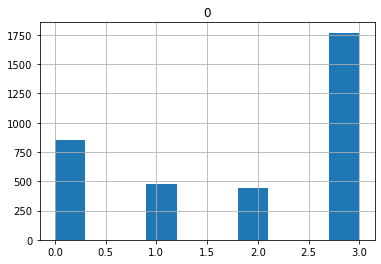

In [126]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
#reduce_train['accuracy_group'].hist()

preds=list(xgb_model.predict(test_features))
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(preds, acum * 100)
print(bound)
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
test_class = list(map(classify, preds))
print(cohen_kappa_score(test_class, test_labels, weights = 'quadratic'))
pd.DataFrame(list(test_class)).hist()

In [127]:
df_top_feature_importance=pd.DataFrame(zip(reduce_train.columns,xgb_model.feature_importances_),\
                                       columns=['features','importance'])
df_top_feature_importance.sort_values(by='importance',ascending=False).head(10)

,features,importance
261,cumcnt_abc5811c,0.104694
194,cm_cnt_2000_Sandcastle Builder (Activity),0.096411
8,Bird_Measurer_incorrect,0.057845
86,cm_cnt_2010_Chest Sorter (Assessment),0.041852
195,Chest_Sorter_incorrect,0.038421
106,accumulated_correct,0.025680
209,cum_gm_tm_Crystals Rule,0.022705
89,cm_cnt_3121_Bird Measurer (Assessment),0.020990
251,cumcnt_12 Monkeys,0.019046
163,Cauldron_Filler_incorrect,0.018637


{0: 0.08486233599243898, 1: 0.08896949887275696, 2: 0.5115065276622772}


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13988a390>]],
      dtype=object)

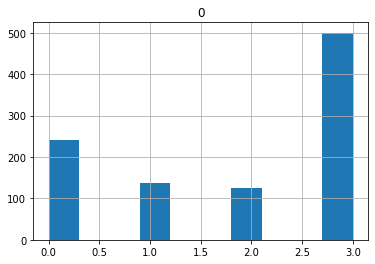

In [128]:
dist = Counter(reduce_train['accuracy_group'])
for k in dist:
    dist[k] /= len(reduce_train)
#reduce_train['accuracy_group'].hist()

preds=list(xgb_model.predict(np.array(ajusted_test)))
acum = 0
bound = {}
for i in range(3):
    acum += dist[i]
    bound[i] = np.percentile(preds, acum * 100)
print(bound)
def classify(x):
    if x <= bound[0]:
        return 0
    elif x <= bound[1]:
        return 1
    elif x <= bound[2]:
        return 2
    else:
        return 3
    
test_class = list(map(classify, preds))
pd.DataFrame(list(test_class)).hist()

##### Conclusion from XGB

<br> Looks like XGB is overfitting becasue there is huge difference between evaluation and test
<br> Feature engineering needs to be done different ways

#### Keras deep learning

<br> With same features will try Keras classification model <br>

In [142]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow import set_random_seed
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.callbacks import EarlyStopping
import keras.initializers

Using TensorFlow backend.


In [252]:
indices=reduce_train.index.values
test_indices=ajusted_test.index.values
labels = np.array(reduce_train['accuracy_group'])
features= reduce_train.drop(['accuracy_group'], axis = 1)
features = np.array(features)

In [253]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
features_scaled = min_max_scaler.fit_transform(features)
test_features_scaled=min_max_scaler.fit_transform(np.array(ajusted_test))
train_features, eval_features, train_labels, eval_labels,idx_train,idx_eval = \
            train_test_split(features_scaled, labels,indices, test_size = 0.2, random_state = 7)

In [288]:
%%time
np.random.seed(12345)
set_random_seed(12345)
model = Sequential()
model.add(BatchNormalization())
model.add(Dense(100, activation='relu',\
                input_dim=train_features.shape[1]))
model.add(Dense(50, activation='relu'))
model.add(Dense(24, activation='relu'))
model.add(Dense(16, activation='relu'))
#model.add(Dense(12, activation='relu'))
model.add(Dense(8, activation='relu'))
#model.add(Dense(6, activation='relu'))
# add output layer
model.add(Dense(4, activation='softmax'))

opt=keras.optimizers.Adam(learning_rate=0.00001, beta_1=0.9, beta_2=0.999, amsgrad=False)
model.compile(optimizer=opt, loss="categorical_crossentropy", metrics=["accuracy"])

# enable early stopping based on mean_squared_error
earlystopping=EarlyStopping(monitor="val_loss", patience=40, verbose=10, mode='auto')

one_hot_train_labels = keras.utils.to_categorical(train_labels, num_classes=4)
one_hot_eval_labels = keras.utils.to_categorical(eval_labels, num_classes=4)
# fit model
result = model.fit(train_features, one_hot_train_labels, epochs=200, batch_size=8,\
                   validation_data=(eval_features, one_hot_eval_labels),callbacks=[earlystopping])
# get predictions
eval_pred = model.predict(eval_features)

test_pred=model.predict(test_features_scaled)

Train on 14152 samples, validate on 3538 samples
Epoch 1/200
14152/14152 [==============================] - 10s 722us/step - loss: 1.3365 - accuracy: 0.4121 - val_loss: 1.2973 - val_accuracy: 0.4949
Epoch 2/200
14152/14152 [==============================] - 8s 595us/step - loss: 1.2788 - accuracy: 0.5048 - val_loss: 1.2558 - val_accuracy: 0.5133
Epoch 3/200
14152/14152 [==============================] - 8s 584us/step - loss: 1.2473 - accuracy: 0.5171 - val_loss: 1.2279 - val_accuracy: 0.5223
Epoch 4/200
14152/14152 [==============================] - 9s 626us/step - loss: 1.2240 - accuracy: 0.5251 - val_loss: 1.2014 - val_accuracy: 0.5302
Epoch 5/200
14152/14152 [==============================] - 9s 624us/step - loss: 1.1994 - accuracy: 0.5437 - val_loss: 1.1712 - val_accuracy: 0.5588
Epoch 6/200
14152/14152 [==============================] - 8s 596us/step - loss: 1.1692 - accuracy: 0.5639 - val_loss: 1.1398 - val_accuracy: 0.5817
Epoch 7/200
14152/14152 [==============================]

14152/14152 [==============================] - 8s 600us/step - loss: 0.6672 - accuracy: 0.7444 - val_loss: 0.6559 - val_accuracy: 0.7561
Epoch 56/200
14152/14152 [==============================] - 8s 594us/step - loss: 0.6696 - accuracy: 0.7417 - val_loss: 0.6526 - val_accuracy: 0.7561
Epoch 57/200
14152/14152 [==============================] - 8s 597us/step - loss: 0.6710 - accuracy: 0.7427 - val_loss: 0.6464 - val_accuracy: 0.7606
Epoch 58/200
14152/14152 [==============================] - 9s 613us/step - loss: 0.6616 - accuracy: 0.7472 - val_loss: 0.6413 - val_accuracy: 0.7603
Epoch 59/200
14152/14152 [==============================] - 9s 619us/step - loss: 0.6501 - accuracy: 0.7528 - val_loss: 0.6382 - val_accuracy: 0.7668
Epoch 60/200
14152/14152 [==============================] - 9s 607us/step - loss: 0.6562 - accuracy: 0.7479 - val_loss: 0.6411 - val_accuracy: 0.7708
Epoch 61/200
14152/14152 [==============================] - 8s 597us/step - loss: 0.6600 - accuracy: 0.7457 - val

14152/14152 [==============================] - 9s 652us/step - loss: 0.5552 - accuracy: 0.7812 - val_loss: 0.5866 - val_accuracy: 0.7880
Epoch 110/200
14152/14152 [==============================] - 9s 633us/step - loss: 0.5538 - accuracy: 0.7860 - val_loss: 0.5819 - val_accuracy: 0.7883
Epoch 111/200
14152/14152 [==============================] - 9s 642us/step - loss: 0.5441 - accuracy: 0.7883 - val_loss: 0.5748 - val_accuracy: 0.7891
Epoch 112/200
14152/14152 [==============================] - 9s 669us/step - loss: 0.5526 - accuracy: 0.7882 - val_loss: 0.5886 - val_accuracy: 0.7824
Epoch 113/200
14152/14152 [==============================] - 9s 659us/step - loss: 0.5495 - accuracy: 0.7861 - val_loss: 0.5683 - val_accuracy: 0.8036
Epoch 114/200
14152/14152 [==============================] - 9s 628us/step - loss: 0.5497 - accuracy: 0.7841 - val_loss: 0.5737 - val_accuracy: 0.8010
Epoch 115/200
14152/14152 [==============================] - 9s 628us/step - loss: 0.5511 - accuracy: 0.7866

14152/14152 [==============================] - 9s 651us/step - loss: 0.5066 - accuracy: 0.8009 - val_loss: 0.5551 - val_accuracy: 0.8115
Epoch 164/200
14152/14152 [==============================] - 9s 638us/step - loss: 0.5092 - accuracy: 0.8005 - val_loss: 0.5606 - val_accuracy: 0.8030
Epoch 165/200
14152/14152 [==============================] - 9s 644us/step - loss: 0.5044 - accuracy: 0.8040 - val_loss: 0.5579 - val_accuracy: 0.7999
Epoch 166/200
14152/14152 [==============================] - 9s 629us/step - loss: 0.5152 - accuracy: 0.7943 - val_loss: 0.5684 - val_accuracy: 0.8061
Epoch 167/200
14152/14152 [==============================] - 9s 662us/step - loss: 0.5144 - accuracy: 0.8011 - val_loss: 0.5671 - val_accuracy: 0.7954
Epoch 168/200
14152/14152 [==============================] - 9s 655us/step - loss: 0.5022 - accuracy: 0.8033 - val_loss: 0.5615 - val_accuracy: 0.8089
Epoch 169/200
14152/14152 [==============================] - 9s 671us/step - loss: 0.5112 - accuracy: 0.8031

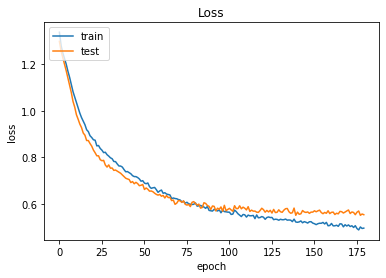

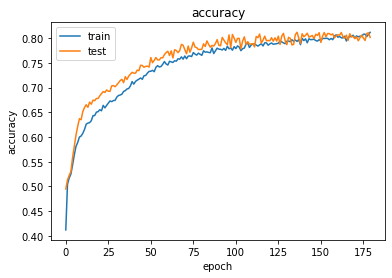

In [289]:
#Plot loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#Plot accuracy
plt.plot(result.history['accuracy'])
plt.plot(result.history['val_accuracy'])
plt.title('accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

0.005585154078962207


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x254610310>]],
      dtype=object)

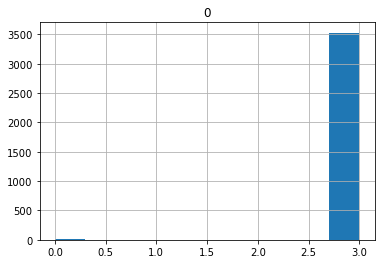

In [290]:
eval_pred_list=[]
for i in range(len(eval_pred)):
    if max(eval_pred[i].astype(int))==1:
        eval_pred_list.append(np.asscalar(np.argwhere(eval_pred[i].astype(int)==1)))
    else:
        eval_pred_list.append(3)
print(cohen_kappa_score(eval_pred_list,eval_labels))
pd.DataFrame(eval_pred_list).hist()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x254608ed0>]],
      dtype=object)

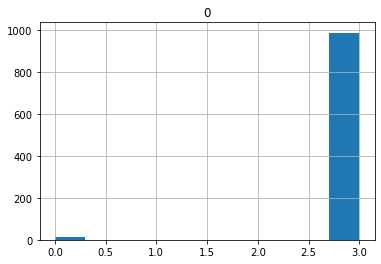

In [291]:
test_pred_list=[]
for i in range(len(test_pred)):
    if max(test_pred[i].astype(int))==1:
        test_pred_list.append(np.asscalar(np.argwhere(test_pred[i].astype(int)==1)))
    else:
        test_pred_list.append(3)
pd.DataFrame(test_pred_list).hist()

##### Conclusion
<br> Tried deep learning with adding different layers and changing other hyperparameters. But
<br> not found any good result. Specially it failed totally to capture any accuracy group other than 
<br> 3. Cohen-Kappa score is also very low. Need different feature engineering to make better prediction.